In [132]:
from IPython.display import clear_output

In [133]:
!pip install pyts
!pip install -U sentence-transformers
clear_output()

In [134]:
!pip install kmedoids
clear_output()

In [135]:
from PivotTree import *
from RuleTree import *

In [136]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import List, Dict, Tuple

import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers

from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier

In [137]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()
X_train = X_train.astype(np.float32) / 255.
X_test = X_test.astype(np.float32) / 255.
y_train, y_test = y_train.flatten(), y_test.flatten()


# split the test into test-validation
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, train_size=1000, test_size=1000, random_state=13)

# subsample the datasets
np.random.seed(13)
train_idx = np.random.choice(len(X_train), size=1000, replace=False)
X_train, y_train = X_train[train_idx], y_train[train_idx]

In [138]:
# download weights
!wget https://storage.googleapis.com/seldon-models/alibi/model_cifar10/checkpoint -P model_cifar10
!wget https://storage.googleapis.com/seldon-models/alibi/model_cifar10/cifar10.ckpt.data-00000-of-00001 -P model_cifar10
!wget https://storage.googleapis.com/seldon-models/alibi/model_cifar10/cifar10.ckpt.index -P model_cifar10

--2024-04-04 12:19:46--  https://storage.googleapis.com/seldon-models/alibi/model_cifar10/checkpoint
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.23.207, 74.125.203.207, 64.233.187.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.23.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 81 [application/octet-stream]
Saving to: ‘model_cifar10/checkpoint.1’

checkpoint.1        100%[===================>]      81  --.-KB/s    in 0s      

2024-04-04 12:19:47 (35.4 MB/s) - ‘model_cifar10/checkpoint.1’ saved [81/81]

--2024-04-04 12:19:47--  https://storage.googleapis.com/seldon-models/alibi/model_cifar10/cifar10.ckpt.data-00000-of-00001
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.23.207, 74.125.203.207, 64.233.187.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.23.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2218891 (2.1M) [applic

In [152]:
# define the network to be used.
model = keras.Sequential([
        layers.InputLayer(input_shape=(32, 32, 3)),
        layers.Conv2D(32, (3, 3), kernel_initializer='he_uniform', padding='same'),
        layers.ReLU(),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), kernel_initializer='he_uniform', padding='same'),
        layers.ReLU(),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.2),
        layers.Conv2D(64, (3, 3), kernel_initializer='he_uniform', padding='same'),
        layers.ReLU(),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), kernel_initializer='he_uniform', padding='same'),
        layers.ReLU(),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),
        layers.Conv2D(128, (3, 3), kernel_initializer='he_uniform', padding='same'),
        layers.ReLU(),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), kernel_initializer='he_uniform', padding='same'),
        layers.ReLU(),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.4),
        layers.Flatten(),
        layers.Dense(128, kernel_initializer='he_uniform', name='feature_layer'),
        layers.ReLU(),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(10)
])

# load the weights
model.load_weights('model_cifar10/cifar10.ckpt');

In [153]:
# define preprocessing function
partial_model = keras.Model(
    inputs=model.inputs,
    outputs=model.get_layer(name='feature_layer').output
)

def preprocess_fn(x: np.ndarray):
    return partial_model(x, training=False).numpy()

In [154]:
train_embeddings = preprocess_fn(X_train)
test_embeddings =preprocess_fn(X_test)

In [155]:
clf = PivotTree(max_depth = 4, allow_oblique_splits = False, force_oblique_splits= False, random_state = 0)

In [156]:
clf.fit(train_embeddings, y_train)

In [157]:
classes_dict = {}
for i, x in enumerate(['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']):
  classes_dict[i] = x
classes_dict


{0: 'plane',
 1: 'car',
 2: 'bird',
 3: 'cat',
 4: 'deer',
 5: 'dog',
 6: 'frog',
 7: 'horse',
 8: 'ship',
 9: 'truck'}

## utils foos

In [186]:
def compute_score(y_validation, predictions):
  balanced_accuracy_score_ = balanced_accuracy_score(y_validation, predictions)
  f1_score_ = f1_score(y_validation, predictions, average='macro')
  accuracy_score_ = accuracy_score(y_validation, predictions)
  precision_score_ = precision_score(y_validation, predictions, average='macro')
  recall_score_ = recall_score(y_validation, predictions, average='macro')

  score_dict = {
        'balanced_accuracy_score': balanced_accuracy_score_,
        'f1_score': f1_score_,
        'accuracy_score': accuracy_score_,
        'precision_score': precision_score_,
        'recall_score': recall_score_
    }

  return score_dict

In [187]:
def extract_values_oblique(data):
    result = []

    for outer_list in data:
        for inner_list in outer_list:
            for item in inner_list:
                node_id = int(item.split(' ')[1])  # Extracting the node ID as an integer

                if 'pivot:' in item:
                    value = int(item.split('pivot: ')[-1])  # Extracting the pivot value as an integer
                    result.append({'node_id': node_id, 'value': value, 'type': 'pivot'})

                elif 'medoid:' in item:
                    value = int(item.split('medoid: ')[-1])  # Extracting the medoid value as an integer
                    result.append({'node_id': node_id, 'value': value, 'type': 'medoid'})

    return result

def extract_values_parallel(data):
    result = []

    for item in data:
        node_id = int(item[0].split(' ')[1])  # Extracting the node ID as an integer

        if 'pivot:' in item[0]:
            value = int(item[0].split('pivot: ')[-1])  # Extracting the pivot value as an integer
            result.append({'node_id': node_id, 'value': value, 'type': 'pivot'})

        elif 'medoid:' in item[0]:
            value = int(item[0].split('medoid: ')[-1])  # Extracting the medoid value as an integer
            result.append({'node_id': node_id, 'value': value, 'type': 'medoid'})

    return result


In [188]:
from RuleTree import *
from PivotTree import *

import sys

import pandas as pd
from sklearn.model_selection import train_test_split
from itertools import product
import time
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import silhouette_score, roc_auc_score, balanced_accuracy_score, f1_score, accuracy_score, recall_score, precision_score

In [189]:
def pivot_tree_selection(params_list, pairwise_dist_matrix, X_curr, y_curr, random_state):

  #initialize empty lists
  X_pivots_discriminative, y_pivots_discriminative = [], []
  X_pivots_descriptive, y_pivots_descriptive = [], []
  X_pivots_used, y_pivots_used = [], []

  discriminative_idxs = []


  #set parameters
  max_depth_clf = params_list['max_depth']
  allow_oblique_splits_clf = params_list['allow_oblique_splits']
  force_oblique_splits_clf = params_list['force_oblique_splits']
  max_oblique_features_clf = params_list['max_oblique_features']
  pivot_oblique_choice_features_clf = params_list['pivot_oblique_choice_features']
  approximation_clf = params_list['approximation']


  random_state_clf = random_state


  #init pivottree and fit it
  pivot_tree = PivotTree(allow_oblique_splits = allow_oblique_splits_clf, force_oblique_splits = force_oblique_splits_clf, random_state = random_state_clf,
                             max_oblique_features=max_oblique_features_clf,max_depth = max_depth_clf, distance_matrix = pairwise_dist_matrix,
                             pivot_oblique_choice_features = pivot_oblique_choice_features_clf, prune_tree = True, pairwise_metric = metric)


  time_selection = 0.0
  start_time = time.process_time()
  pivot_tree.fit(X_curr, y_curr) #fit the pivot_tree with current configuration
  end_time = time.process_time()

  time_selection = end_time - start_time

  #retrieve nodes
  nodes = [node for node in list(pivot_tree._node_dict.values())] #get nodes

  #get descriptive
  X_descriptive = [node.X_pivot_descriptive for node in nodes if type(node.X_pivot_descriptive) != type(None)]
  y_descriptive  = [node.y_pivot_descriptive for node in nodes if type(node.y_pivot_descriptive) != type(None)]

  #get discriminative
  X_discriminative_pivot_indexes = np.concatenate([node.discriminative_pivot_indexes for node in nodes if type(node.discriminative_pivot_indexes) != type(None)]).astype(int)

  X_discriminative = X_curr[X_discriminative_pivot_indexes]
  y_discriminative = y_curr[X_discriminative_pivot_indexes]

  X_pivots_discriminative += [x for x in X_discriminative]
  y_pivots_discriminative += [x for x in y_discriminative]

  X_pivots_descriptive += sum([x for x in X_descriptive], [])
  y_pivots_descriptive += sum([x for x in y_descriptive],[])

  idxs_pivots_used = [node.pivot_used for node in nodes if type(node.pivot_used) != type(None)]

  if force_oblique_splits_clf:
      idxs_pivots_used = [x['value'] for x in extract_values_oblique(idxs_pivots_used)]
  else:
      idxs_pivots_used = [x['value'] for x in extract_values_parallel(idxs_pivots_used)]

  X_pivots_used += [x for x in X_curr[idxs_pivots_used]]
  y_pivots_used += [x for x in y_curr[idxs_pivots_used]]

  #return fitted pivot_tree and prototypes extracted

  prototypes = {'X_pivots_discriminative': X_pivots_discriminative, 'y_pivots_discriminative' : y_pivots_discriminative,
                'X_pivots_descriptive': X_pivots_descriptive, 'y_pivots_descriptive' : y_pivots_descriptive,
                'X_pivots_used' : X_pivots_used, 'y_pivots_used' : y_pivots_used,
                'X_pivots_discriminative_descriptive' : X_pivots_discriminative + X_pivots_descriptive,
                'y_pivots_discriminative_descriptive' : y_pivots_discriminative + y_pivots_descriptive,

                }

  return pivot_tree, prototypes, time_selection


In [190]:

def generate_param_configurations(configurations):
    keys, values_list = zip(*configurations.items())
    param_combinations = list(product(*values_list))

    result_configurations = []
    for combination in param_combinations:
        config_dict = dict(zip(keys, combination))
        result_configurations.append(config_dict)

    return result_configurations

## Extraction

In [191]:
approximation = False
metric = 'euclidean'
#pivot Tree parameters that are relevant for us
configurations = {'max_depth': [2,3,4],
                  'allow_oblique_splits' : [False],
                  'force_oblique_splits': [False],
                  'max_oblique_features' : [2],
                  'pivot_oblique_choice_features' : [None,2,3,4],
                  'approximation' : [approximation]
                 }

possible_configurations = [x for x in generate_param_configurations(configurations)]


In [192]:
params_list = possible_configurations[-4]
params_list

{'max_depth': 4,
 'allow_oblique_splits': False,
 'force_oblique_splits': False,
 'max_oblique_features': 2,
 'pivot_oblique_choice_features': None,
 'approximation': False}

In [193]:
pairwise_dist_matrix = pairwise_distances(train_embeddings, metric = 'euclidean')

In [194]:
pivot_tree, prototypes, time_selection = pivot_tree_selection(params_list, pairwise_dist_matrix, train_embeddings, y_train, random_state = 0)

In [195]:
print('PivotTree')
print(pivot_tree.print_tree())
print('')

y_pred = pivot_tree.predict(test_embeddings)
print('Accuracy', accuracy_score(y_test, y_pred))

PivotTree
[(True, ['node_id: 0  pivot: 574'], [1.0], 127.90208053588867, False, 0), (False, 0, 103, 0.103, 1, 1), (True, ['node_id: 2  pivot: 65'], [1.0], 163.16980743408203, False, 1), (False, 1, 103, 0.103, 5, 2), (True, ['node_id: 6  pivot: 351'], [1.0], 118.9583625793457, False, 2), (True, ['node_id: 9  pivot: 308'], [1.0], 121.63386535644531, False, 3), (False, 4, 99, 0.099, 13, 4), (False, 3, 3, 0.003, 14, 4), (True, ['node_id: 10  pivot: 781'], [1.0], 109.68937683105469, False, 3), (False, 5, 103, 0.103, 15, 4), (False, 2, 589, 0.589, 16, 4)]
|-+ if node_id: 0  pivot: 574 <= 127.9:
  |--> label: 0 (103, 0.1)
  |-+ if node_id: 2  pivot: 65 <= 163.17:
    |--> label: 1 (103, 0.1)
    |-+ if node_id: 6  pivot: 351 <= 118.96:
      |-+ if node_id: 9  pivot: 308 <= 121.63:
        |--> label: 4 (99, 0.1)
        |--> label: 3 (3, 0.0)
      |-+ if node_id: 10  pivot: 781 <= 109.69:
        |--> label: 5 (103, 0.1)
        |--> label: 2 (589, 0.59)


Accuracy 0.017


In [196]:
len(prototypes['X_pivots_discriminative_descriptive'])
len(prototypes['X_pivots_used'])

5

In [197]:
idxs = []
for i, x in enumerate(train_embeddings):
  if list(x) in [list(k) for k in prototypes['X_pivots_used']]:
    idxs += [i]

idxs

[65, 308, 351, 574, 781]

2 bird


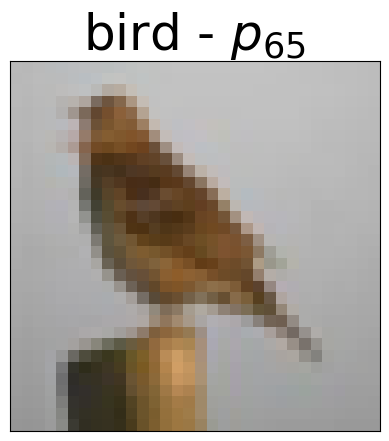

7 horse


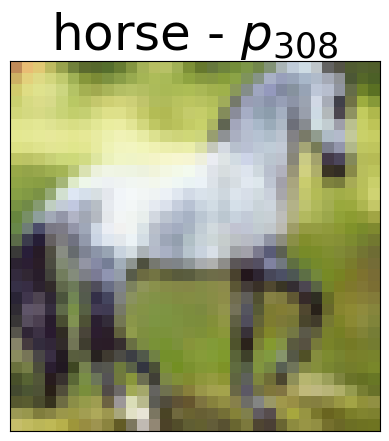

7 horse


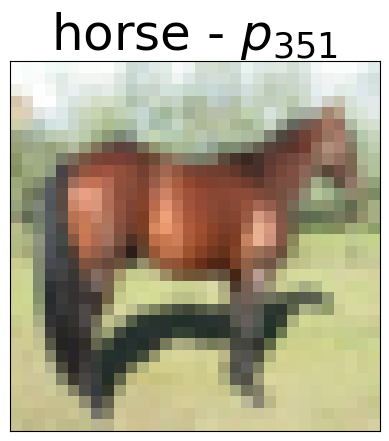

1 car


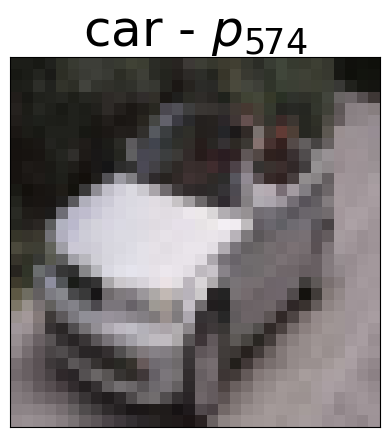

9 truck


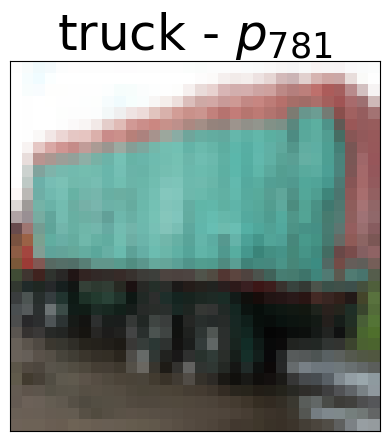

In [198]:
for id in idxs:
  plt.imshow(X_train[id], interpolation='nearest')
  print(y_train[id], classes_dict[y_train[id]])
  plt.xticks([])
  plt.yticks([])
  num_piv = id

  plt.title(f"{classes_dict[y_train[id]]} - $p_{{{num_piv}}}$", fontsize=36)

  plt.savefig(str(id) + '_' + 'img_pivots.png', format = 'png', bbox_inches = 'tight' , dpi = 300)

  plt.show()

In [199]:
X_pivots_name = 'X_pivots_used'

In [200]:
#train a decision tree on the mapped space
X_train_reduced, time_pairwise_training = pariwise_computation(train_embeddings, prototypes[X_pivots_name], metric) #reduce training set
X_test_reduced, time_pairwise_test =  pariwise_computation(test_embeddings, prototypes[X_pivots_name], metric) #reduce validation set

In [201]:
knn = KNeighborsClassifier(n_neighbors=5, metric = metric)
knn.fit(X_train_reduced, y_train)
predictions = knn.predict(X_test_reduced)
KNN_score_dict = compute_score(y_test, predictions)

In [202]:
KNN_score_dict

{'balanced_accuracy_score': 0.6543904136025989,
 'f1_score': 0.6585685853001801,
 'accuracy_score': 0.654,
 'precision_score': 0.6680338243118944,
 'recall_score': 0.6543904136025989}

In [203]:
dt = DecisionTreeClassifier(max_depth = 4, min_samples_leaf = 3, min_samples_split = 5, random_state = 0)
dt.fit(X_train_reduced, y_train)
predictions = dt.predict(X_test_reduced)
DT_score_dict = compute_score(y_test, predictions)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [204]:
DT_score_dict

{'balanced_accuracy_score': 0.45547467149148935,
 'f1_score': 0.3915424690260926,
 'accuracy_score': 0.453,
 'precision_score': 0.42788771847052187,
 'recall_score': 0.45547467149148935}

In [205]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.tree import export_text


In [206]:
print('DecisionTreeClassifier')
print(export_text(dt, feature_names=idxs))
print('')

DecisionTreeClassifier
|--- 65 <= 127.90
|   |--- 308 <= 213.21
|   |   |--- 574 <= 151.23
|   |   |   |--- class: 1
|   |   |--- 574 >  151.23
|   |   |   |--- class: 1
|   |--- 308 >  213.21
|   |   |--- class: 1
|--- 65 >  127.90
|   |--- 308 <= 163.17
|   |   |--- 308 <= 161.79
|   |   |   |--- 781 <= 157.24
|   |   |   |   |--- class: 2
|   |   |   |--- 781 >  157.24
|   |   |   |   |--- class: 2
|   |   |--- 308 >  161.79
|   |   |   |--- class: 2
|   |--- 308 >  163.17
|   |   |--- 351 <= 118.96
|   |   |   |--- 574 <= 121.63
|   |   |   |   |--- class: 7
|   |   |   |--- 574 >  121.63
|   |   |   |   |--- class: 4
|   |   |--- 351 >  118.96
|   |   |   |--- 781 <= 109.69
|   |   |   |   |--- class: 9
|   |   |   |--- 781 >  109.69
|   |   |   |   |--- class: 3




In [207]:
ids_test = [x for x in range(1000) if y_test[x] == 2]
#ids_test

2 bird


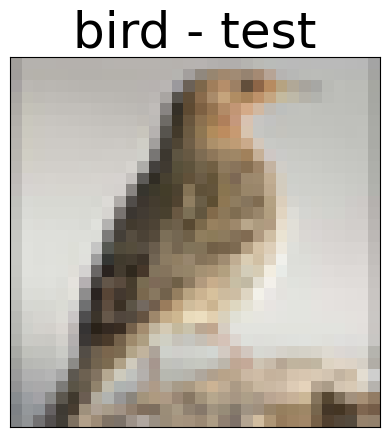

In [208]:
id_test = 447

##500 vabenne

plt.imshow(X_test[id_test], interpolation='nearest')
print(y_test[id_test], classes_dict[y_test[id_test]])
plt.xticks([])
plt.yticks([])


#plt.title(f"{classes_dict[y_test[id_test]]} - $p_{{{id_test}}}$", fontsize=36)
plt.title(f"{classes_dict[y_test[id_test]]} - test", fontsize=36)


plt.savefig(str(id_test) + '_' + 'img_test_instance.png', format = 'png', bbox_inches = 'tight' , dpi = 300)
plt.show()


In [209]:
for x in ids_test:
  pred = knn.predict([X_test_reduced[x]])
  if pred == y_test[x]:
    1
    #print(x)



In [210]:
knn.predict([X_test_reduced[id_test]])

array([2], dtype=uint8)

In [211]:
from sklearn.neighbors import NearestNeighbors

In [212]:
neigh = NearestNeighbors(n_neighbors=5, radius=1.0)
neigh.fit(X_train_reduced)

NearestNeighbors()

In [213]:
indxs_nearest = neigh.kneighbors([X_test_reduced[id_test]], 5, return_distance=True)
indxs_nearest

(array([[20.55221412, 24.42530279, 24.42947128, 24.65075312, 27.90356703]]),
 array([[105, 441, 977, 410, 501]]))

2 bird


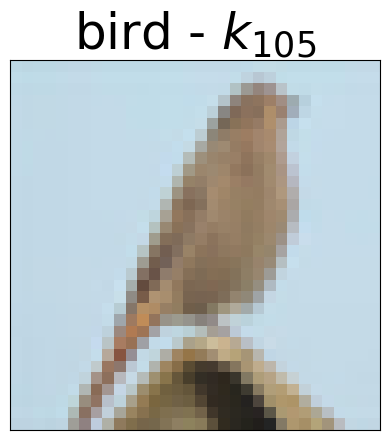

2 bird


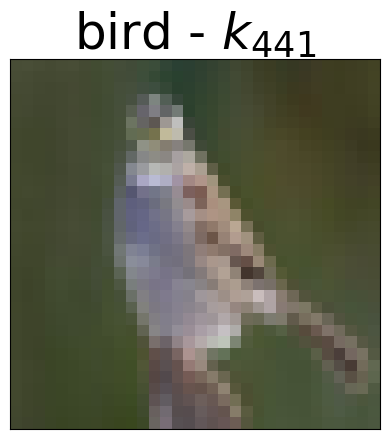

2 bird


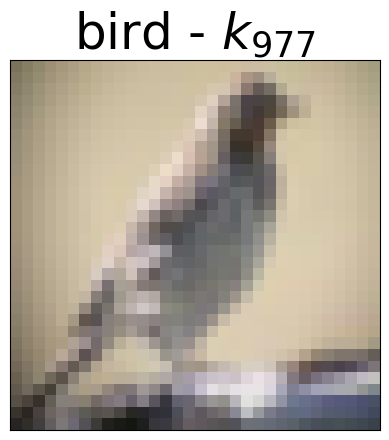

2 bird


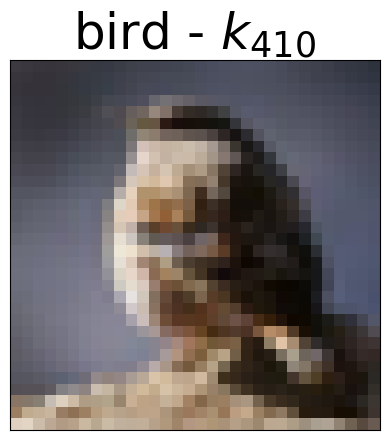

2 bird


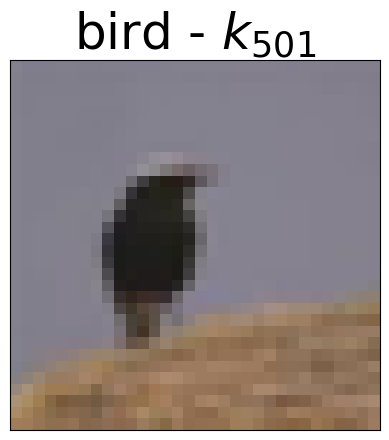

In [214]:
for id in indxs_nearest[1][0]:
  plt.imshow(X_train[id], interpolation='nearest')
  print(y_train[id], classes_dict[y_train[id]])
  plt.xticks([])
  plt.yticks([])


  plt.title(f"{classes_dict[y_train[id]]} - $k_{{{id}}}$", fontsize=36)
  plt.savefig(str(id) + '_' + 'img_neighs.png', format = 'png', bbox_inches = 'tight' , dpi = 300)

  plt.show()

In [215]:
ids_test = [x for x in range(1000) if y_test[x] == 3]
#ids_test

In [216]:
ids_test[3]

27

3 cat


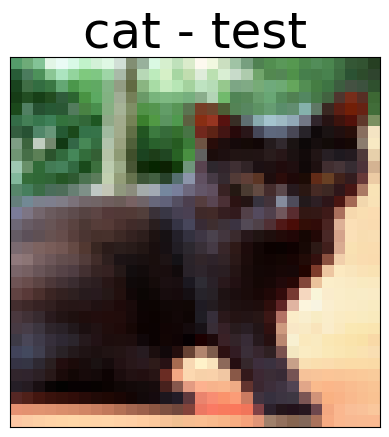

In [217]:
id_test = 27

##500 vabenne

plt.imshow(X_test[id_test], interpolation='nearest')
print(y_test[id_test], classes_dict[y_test[id_test]])
plt.xticks([])
plt.yticks([])


plt.title(classes_dict[y_test[id_test]], fontsize = 36)
plt.title(f"{classes_dict[y_test[id_test]]} - test", fontsize=36)

plt.savefig(str(id_test) + '_' + 'img_test_instance.png', format = 'png', bbox_inches = 'tight' , dpi = 300)
plt.show()


In [222]:
knn.predict([X_test_reduced[id_test]])

array([3], dtype=uint8)

In [223]:
from sklearn.neighbors import NearestNeighbors

In [224]:
neigh = NearestNeighbors(n_neighbors=5, radius=1.0)
neigh.fit(X_train_reduced)

NearestNeighbors()

In [225]:
indxs_nearest = neigh.kneighbors([X_test_reduced[id_test]], 5, return_distance=True)
indxs_nearest

(array([[10.02588916, 10.21167201, 10.56053898, 11.29363051, 11.50749316]]),
 array([[573, 115, 285,   8,  99]]))

4 deer


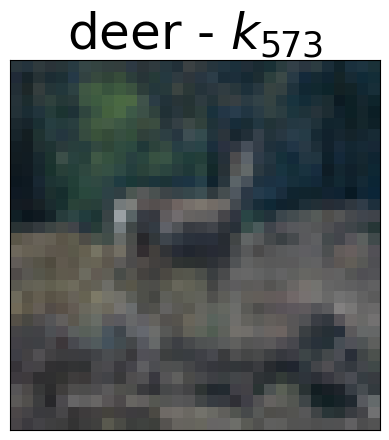

4 deer


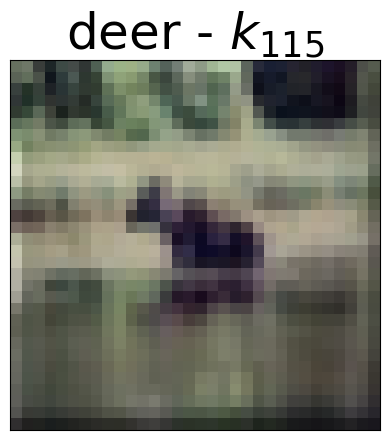

3 cat


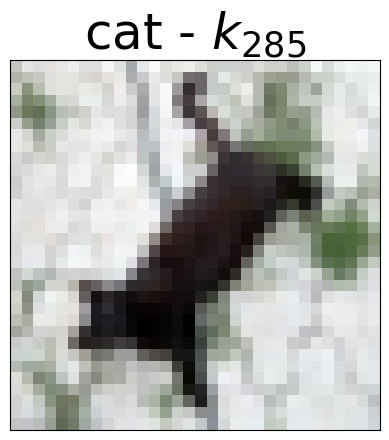

3 cat


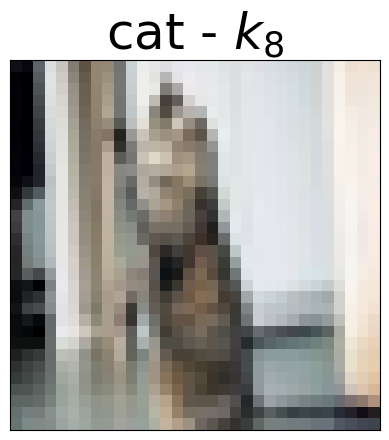

3 cat


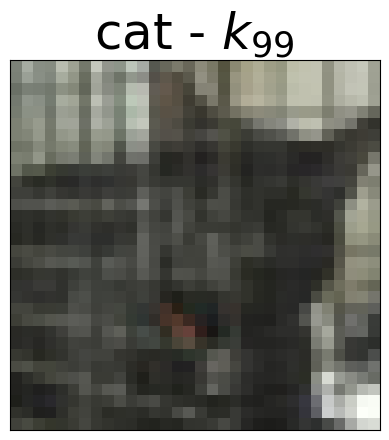

In [226]:
for id in indxs_nearest[1][0]:
  plt.imshow(X_train[id], interpolation='nearest')
  print(y_train[id], classes_dict[y_train[id]])
  plt.xticks([])
  plt.yticks([])

  plt.title(f"{classes_dict[y_train[id]]} - $k_{{{id}}}$", fontsize=36)


  plt.savefig(str(id) + '_' + 'img_neighs.png', format = 'png', bbox_inches = 'tight' , dpi = 300)

  plt.show()

### Visualization with time series


In [323]:
from pyts.datasets import load_gunpoint

In [324]:
X_train, X_test, y_train, y_test = load_gunpoint(return_X_y=True)

In [325]:
y_train = y_train - 1
y_test = y_test - 1
y_train

array([1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0,
       0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0,
       1, 1, 0, 1, 0, 1])

In [326]:
X_train.shape

(50, 150)

In [327]:
classes_dict = {0 : 'gun', 1 : 'no gun'}

In [328]:
approximation = False
metric = 'euclidean'
#pivot Tree parameters that are relevant for us
configurations = {'max_depth': [2,3,4],
                  'allow_oblique_splits' : [False],
                  'force_oblique_splits': [False],
                  'max_oblique_features' : [2],
                  'pivot_oblique_choice_features' : [None,2,3,4],
                  'approximation' : [approximation]
                 }

possible_configurations = [x for x in generate_param_configurations(configurations)]


In [329]:
params_list = possible_configurations[-4]
params_list

{'max_depth': 4,
 'allow_oblique_splits': False,
 'force_oblique_splits': False,
 'max_oblique_features': 2,
 'pivot_oblique_choice_features': None,
 'approximation': False}

In [330]:
pairwise_dist_matrix = pairwise_distances(X_train, metric = 'euclidean')

In [331]:
pivot_tree, prototypes, time_selection = pivot_tree_selection(params_list, pairwise_dist_matrix, X_train, y_train, random_state = 7)

In [332]:
print('PivotTree')
print(pivot_tree.print_tree())
print('')

y_pred = pivot_tree.predict(X_test)
print('Accuracy', accuracy_score(y_test, y_pred))

PivotTree
[(True, ['node_id: 0  pivot: 10'], [1.0], 6.237068176269531, False, 0), (True, ['node_id: 1  pivot: 45'], [1.0], 1.3805697560310364, False, 1), (False, 1, 3, 0.06, 3, 2), (False, 0, 17, 0.34, 4, 2), (True, ['node_id: 2  pivot: 41'], [1.0], 6.682602643966675, False, 1), (False, 0, 6, 0.12, 5, 2), (False, 1, 24, 0.48, 6, 2)]
|-+ if node_id: 0  pivot: 10 <= 6.24:
  |-+ if node_id: 1  pivot: 45 <= 1.38:
    |--> label: 1 (3, 0.06)
    |--> label: 0 (17, 0.34)
  |-+ if node_id: 2  pivot: 41 <= 6.68:
    |--> label: 0 (6, 0.12)
    |--> label: 1 (24, 0.48)


Accuracy 0.8066666666666666


In [333]:
len(prototypes['X_pivots_discriminative_descriptive'])
len(prototypes['X_pivots_used'])

3

In [334]:
idxs = []
for i, x in enumerate(X_train):
  if list(x) in [list(k) for k in prototypes['X_pivots_used']]:
    idxs += [i]

idxs

[10, 41, 45]

0 gun
0 gun
1 no gun


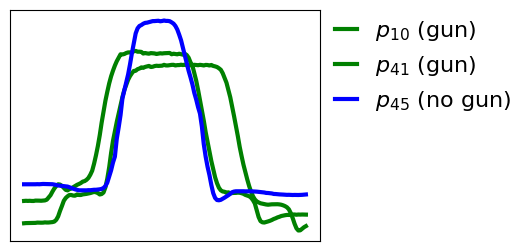

In [335]:
plt.figure(figsize = (4,3))
for i, id in enumerate(idxs):
  class_ref =  classes_dict[y_train[id]]
 # plt.plot(X_train[id], lw = 3, label = r'$p_%s$ (%s)'%(id,class_ref), c = 'b' if 'no' in class_ref else 'g')
  plt.plot(X_train[id], lw=3, label=f'$p_{{{id}}}$ ({class_ref})', c='b' if 'no' in class_ref else 'g')

  print(y_train[id], classes_dict[y_train[id]])


plt.xticks([])
plt.yticks([])

plt.legend(frameon = False, fontsize=16, handlelength  = 1, bbox_to_anchor=(0.5, 0., 1.18, 1.05))
plt.savefig('ts_pivots.png', format = 'png', bbox_inches = 'tight' , dpi = 300)
plt.show()

In [336]:
X_pivots_name = 'X_pivots_used'

In [337]:
#train a decision tree on the mapped space
X_train_reduced, time_pairwise_training = pariwise_computation(X_train, prototypes[X_pivots_name], metric) #reduce training set
X_test_reduced, time_pairwise_test =  pariwise_computation(X_test, prototypes[X_pivots_name], metric) #reduce validation set

In [338]:
knn = KNeighborsClassifier(n_neighbors=5, metric = metric)
knn.fit(X_train_reduced, y_train)
predictions = knn.predict(X_test_reduced)
KNN_score_dict = compute_score(y_test, predictions)

In [339]:
KNN_score_dict

{'balanced_accuracy_score': 0.7795163584637268,
 'f1_score': 0.7795198432141107,
 'accuracy_score': 0.78,
 'precision_score': 0.7812667740203971,
 'recall_score': 0.7795163584637268}

In [340]:
dt = DecisionTreeClassifier(max_depth = 4, min_samples_leaf = 3, min_samples_split = 5, random_state = 0)
dt.fit(X_train_reduced, y_train)
predictions = dt.predict(X_test_reduced)
DT_score_dict = compute_score(y_test, predictions)

In [341]:
DT_score_dict

{'balanced_accuracy_score': 0.7670697012802276,
 'f1_score': 0.7665732959850606,
 'accuracy_score': 0.7666666666666667,
 'precision_score': 0.7677839187020858,
 'recall_score': 0.7670697012802276}

In [342]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.tree import export_text


In [343]:
print('DecisionTreeClassifier')
print(export_text(dt, feature_names=idxs))
print('')

DecisionTreeClassifier
|--- 10 <= 6.24
|   |--- 45 <= 8.58
|   |   |--- class: 0
|   |--- 45 >  8.58
|   |   |--- class: 1
|--- 10 >  6.24
|   |--- 45 <= 6.68
|   |   |--- 41 <= 8.07
|   |   |   |--- class: 0
|   |   |--- 41 >  8.07
|   |   |   |--- class: 0
|   |--- 45 >  6.68
|   |   |--- 41 <= 3.08
|   |   |   |--- class: 1
|   |   |--- 41 >  3.08
|   |   |   |--- class: 1




0 gun


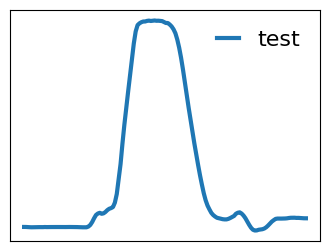

In [344]:
id_test = 90


plt.figure(figsize = (4,3))


#plt.plot(X_test[id_test], lw = 3, label = f'$p_{{{id_test}}}$ ')

#plt.plot(X_test[id_test], lw = 3, label=f'$p_{{{id_test}}}$' )
#plt.plot(X_train[id], lw=3, label=f'$p_{{{id}}}$ ({class_ref})', c='b' if 'no' in class_ref else 'g')

plt.plot(X_test[id_test], lw = 3, label = 'test')



print(y_test[id_test], classes_dict[y_test[id_test]])

plt.xticks([])
plt.yticks([])

plt.legend(frameon = False, fontsize = 16, handlelength  = 1)
plt.savefig('ts_test_instance.png', format = 'png', bbox_inches = 'tight' , dpi = 300)
plt.show()

In [345]:
knn.predict([X_test_reduced[id_test]])

array([0])

In [346]:
from sklearn.neighbors import NearestNeighbors

In [347]:
neigh = NearestNeighbors(n_neighbors=5, radius=1.0)
neigh.fit(X_train_reduced)

NearestNeighbors()

In [348]:
indxs_nearest = neigh.kneighbors([X_test_reduced[id_test]], 5, return_distance=True)
indxs_nearest

(array([[0.25408941, 0.29495518, 0.54487042, 0.83995863, 1.0352149 ]]),
 array([[34, 35, 24, 48, 37]]))

1 no gun
0 gun
0 gun
0 gun
1 no gun


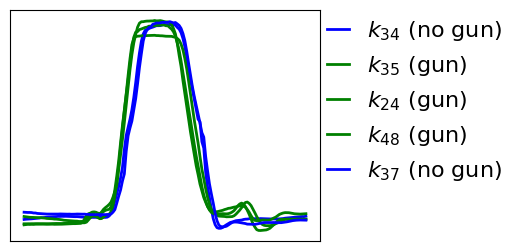

In [349]:
plt.figure(figsize = (4,3))

for i, id in enumerate(indxs_nearest[1][0]):
  class_ref =  classes_dict[y_train[id]]
 # plt.plot(X_train[id], lw = 2, label = r'$x_%s$ (%s)'%(i,class_ref), c = 'b' if 'no' in class_ref else 'g')
  plt.plot(X_train[id], lw=2, label=f'$k_{{{id}}}$ ({class_ref})', c='b' if 'no' in class_ref else 'g')


  print(y_train[id], classes_dict[y_train[id]])



plt.xticks([])
plt.yticks([])

plt.legend(frameon = False, fontsize=16, handlelength  = 1, bbox_to_anchor=(0.5, 0., 1.15, 1.05))
plt.savefig('ts_neighs.png', format = 'png', bbox_inches = 'tight' , dpi = 300)
plt.show()




#### ECG

In [350]:
df = pd.read_csv('ecg5000_vis.csv')
X = df.drop('class', axis = 1).values
y = np.array(df['class'])

from sklearn.model_selection import train_test_split


In [351]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [352]:
y_train

array([0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 2, 0, 2,
       0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 0, 1, 0, 3, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 1, 1, 3, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1,
       0, 3, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 2, 0, 3, 0, 1, 1, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 3, 0, 0, 0, 0, 1, 0, 1, 0, 3, 1, 0, 1,
       1, 0, 0, 0, 1, 0, 2, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1,
       1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 3, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0,
       1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 3, 0])

In [353]:
X_train.shape

(268, 140)

In [354]:
classes_dict = {0 : 'normal', 1 : 'R-on-T', 2 : 'sup_ecto', 3 : 'prem_ven', 4 : 'unclass'}
classes_dict

color_dict_ecg = {'normal' : 'b', 'R-on-T' : 'g', 'sup_ecto' : 'r', 3 : 'prem_ven', 4 : 'unclass'}


In [355]:
approximation = False
metric = 'euclidean'
#pivot Tree parameters that are relevant for us
configurations = {'max_depth': [2,3,4],
                  'allow_oblique_splits' : [False],
                  'force_oblique_splits': [False],
                  'max_oblique_features' : [2],
                  'pivot_oblique_choice_features' : [None,2,3,4],
                  'approximation' : [approximation]
                 }

possible_configurations = [x for x in generate_param_configurations(configurations)]


In [356]:
params_list = possible_configurations[-4]
params_list

{'max_depth': 4,
 'allow_oblique_splits': False,
 'force_oblique_splits': False,
 'max_oblique_features': 2,
 'pivot_oblique_choice_features': None,
 'approximation': False}

In [357]:
pairwise_dist_matrix = pairwise_distances(X_train, metric = 'euclidean')

In [358]:
pivot_tree, prototypes, time_selection = pivot_tree_selection(params_list, pairwise_dist_matrix, X_train, y_train, random_state = 0)

In [359]:
print('PivotTree')
print(pivot_tree.print_tree())
print('')

y_pred = pivot_tree.predict(X_test)
print('Accuracy', accuracy_score(y_test, y_pred))

PivotTree
[(True, ['node_id: 0  pivot: 196'], [1.0], 11.85390329360962, False, 0), (False, 0, 157, 0.585820895522388, 1, 1), (True, ['node_id: 2  pivot: 227'], [1.0], 10.882364273071289, False, 1), (False, 1, 84, 0.31343283582089554, 3, 2), (True, ['node_id: 4  pivot: 41'], [1.0], 15.237029075622559, False, 2), (True, ['node_id: 7  pivot: 41'], [1.0], 14.494997024536133, False, 3), (False, 0, 3, 0.011194029850746268, 11, 4), (False, 3, 7, 0.026119402985074626, 12, 4), (True, ['node_id: 8  pivot: 19'], [1.0], 4.831786155700684, False, 3), (False, 2, 3, 0.011194029850746268, 13, 4), (False, 1, 14, 0.05223880597014925, 14, 4)]
|-+ if node_id: 0  pivot: 196 <= 11.85:
  |--> label: 0 (157, 0.59)
  |-+ if node_id: 2  pivot: 227 <= 10.88:
    |--> label: 1 (84, 0.31)
    |-+ if node_id: 4  pivot: 41 <= 15.24:
      |-+ if node_id: 7  pivot: 41 <= 14.49:
        |--> label: 0 (3, 0.01)
        |--> label: 3 (7, 0.03)
      |-+ if node_id: 8  pivot: 19 <= 4.83:
        |--> label: 2 (3, 0.01)
 

In [360]:
len(prototypes['X_pivots_discriminative_descriptive'])
len(prototypes['X_pivots_used'])

5

In [361]:
for prot in prototypes['X_pivots_used']:
  prot
  for i, el in enumerate(X_train):
    if list(prot) == list(el):
      print(i)

196
227
41
41
19


In [362]:
idxs = []
for i, x in enumerate(X_train):
  if list(x) in [list(k) for k in prototypes['X_pivots_used']]:
    idxs += [i]

idxs

[19, 41, 196, 227]

2 sup_ecto
0 normal
0 normal
1 R-on-T


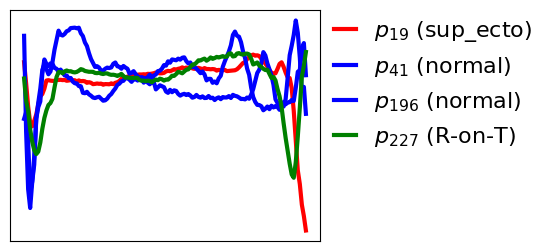

In [363]:
plt.figure(figsize = (4,3))
for i, id in enumerate(idxs):
  class_ref =  classes_dict[y_train[id]]
 # plt.plot(X_train[id], lw = 3, label = r'$p_%s$ (%s)'%(id,class_ref), c = 'b' if 'no' in class_ref else 'g')
 #plt.plot(X_train[id], lw=3, label=f'$p_{{{id}}}$ ({class_ref})', c='b' if 'no' in class_ref else 'g')
  plt.plot(X_train[id], lw=3, label=f'$p_{{{id}}}$ ({class_ref})', c=color_dict_ecg[class_ref])




  print(y_train[id], classes_dict[y_train[id]])


plt.xticks([])
plt.yticks([])

plt.legend(frameon = False, fontsize=16, handlelength  = 1, bbox_to_anchor=(0.5, 0., 1.25, 1.05))
plt.savefig('ecg_ts_pivots.png', format = 'png', bbox_inches = 'tight' , dpi = 300)
plt.show()

In [364]:
X_pivots_name = 'X_pivots_used'

In [365]:
prots = prototypes['X_pivots_used']
del prots[2]
prots

[array([ 1.6651624e+00, -1.8767018e+00, -4.0078711e+00, -4.7026004e+00,
        -3.7473777e+00, -2.8031376e+00, -1.3935652e+00, -9.7407338e-01,
        -7.6258356e-01,  2.7104666e-01,  7.9035661e-01,  6.3006973e-01,
         5.4428328e-01,  6.4598661e-01,  6.2916340e-01,  4.7869008e-01,
         4.4724179e-01,  3.3176385e-01,  4.1655820e-01,  3.0706837e-01,
         1.9886117e-01,  1.9744692e-01,  9.5357191e-02,  1.0685670e-01,
        -2.6866202e-02, -8.9092242e-02, -9.4734488e-02, -1.9417589e-01,
        -1.9938621e-01, -4.4422130e-01, -4.5754215e-01, -4.0570204e-01,
        -4.9910254e-01, -5.4963905e-01, -6.1851550e-01, -6.3739541e-01,
        -6.0640437e-01, -5.8903800e-01, -6.6438928e-01, -7.3401673e-01,
        -7.2056221e-01, -6.5806637e-01, -5.5287574e-01, -4.8756109e-01,
        -3.7594529e-01, -2.8263356e-01, -1.4899189e-01, -1.0424535e-01,
        -1.4053764e-02,  2.0039268e-03,  1.0603414e-01,  9.9188969e-02,
         4.1905433e-02, -3.7137389e-02,  6.1541228e-02,  6.29613

In [366]:
#train a decision tree on the mapped space
X_train_reduced, time_pairwise_training = pariwise_computation(X_train, prots, metric) #reduce training set
X_test_reduced, time_pairwise_test =  pariwise_computation(X_test, prots, metric) #reduce validation set

In [367]:
X_train_reduced.shape

(268, 4)

In [368]:
knn = KNeighborsClassifier(n_neighbors=5, metric = metric)
knn.fit(X_train_reduced, y_train)
predictions = knn.predict(X_test_reduced)
KNN_score_dict = compute_score(y_test, predictions)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [369]:
KNN_score_dict

{'balanced_accuracy_score': 0.4,
 'f1_score': 0.38138170178714326,
 'accuracy_score': 0.9318181818181818,
 'precision_score': 0.3655609756097561,
 'recall_score': 0.4}

In [370]:
dt = DecisionTreeClassifier(max_depth = 4, min_samples_leaf = 3, min_samples_split = 5, random_state = 0)
dt.fit(X_train_reduced, y_train)
predictions = dt.predict(X_test_reduced)
DT_score_dict = compute_score(y_test, predictions)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [371]:
DT_score_dict

{'balanced_accuracy_score': 0.6427689594356261,
 'f1_score': 0.6241318494192057,
 'accuracy_score': 0.946969696969697,
 'precision_score': 0.629753086419753,
 'recall_score': 0.6427689594356261}

In [372]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.tree import export_text


In [373]:
print('DecisionTreeClassifier')
print(export_text(dt, feature_names=idxs))
print('')

DecisionTreeClassifier
|--- 19 <= 11.85
|   |--- class: 0
|--- 19 >  11.85
|   |--- 41 <= 10.88
|   |   |--- 41 <= 4.73
|   |   |   |--- 196 <= 14.47
|   |   |   |   |--- class: 1
|   |   |   |--- 196 >  14.47
|   |   |   |   |--- class: 1
|   |   |--- 41 >  4.73
|   |   |   |--- 196 <= 14.78
|   |   |   |   |--- class: 1
|   |   |   |--- 196 >  14.78
|   |   |   |   |--- class: 1
|   |--- 41 >  10.88
|   |   |--- 196 <= 15.24
|   |   |   |--- 196 <= 14.49
|   |   |   |   |--- class: 0
|   |   |   |--- 196 >  14.49
|   |   |   |   |--- class: 3
|   |   |--- 196 >  15.24
|   |   |   |--- 227 <= 4.83
|   |   |   |   |--- class: 2
|   |   |   |--- 227 >  4.83
|   |   |   |   |--- class: 1




0 normal


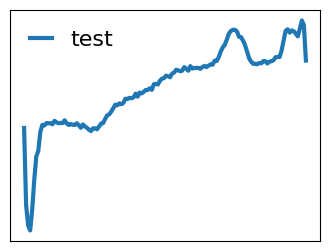

In [374]:
id_test = 50

plt.figure(figsize = (4,3))
#plt.plot(X_test[id_test], lw = 3, label = f'$p_{{{id_test}}}$ ')

#plt.plot(X_test[id_test], lw = 3, label=f'$p_{{{id_test}}}$' )
#plt.plot(X_train[id], lw=3, label=f'$p_{{{id}}}$ ({class_ref})', c='b' if 'no' in class_ref else 'g')
plt.plot(X_test[id_test], lw = 3, label = 'test')


print(y_test[id_test], classes_dict[y_test[id_test]])

plt.xticks([])
plt.yticks([])

plt.legend(frameon = False, fontsize = 16, handlelength  = 1)
plt.savefig('ecg_ts_test_instance.png', format = 'png', bbox_inches = 'tight' , dpi = 300)
plt.show()

In [375]:
knn.predict([X_test_reduced[id_test]])

array([0])

In [376]:
from sklearn.neighbors import NearestNeighbors

In [377]:
neigh = NearestNeighbors(n_neighbors=5, radius=1.0)
neigh.fit(X_train_reduced)

NearestNeighbors()

In [378]:
indxs_nearest = neigh.kneighbors([X_test_reduced[id_test]], 5, return_distance=True)
indxs_nearest

(array([[0.58962467, 0.66240805, 0.99888856, 1.21197698, 1.33709668]]),
 array([[  2,  90, 147, 265, 243]]))

0 normal
0 normal
0 normal
0 normal
0 normal


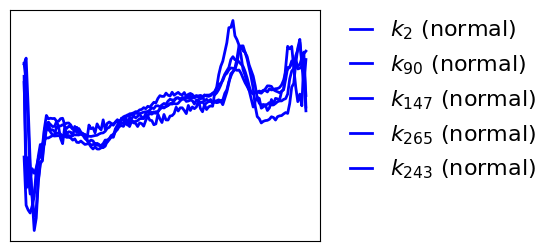

In [379]:
plt.figure(figsize = (4,3))

for i, id in enumerate(indxs_nearest[1][0]):
  class_ref =  classes_dict[y_train[id]]
 # plt.plot(X_train[id], lw = 2, label = r'$x_%s$ (%s)'%(i,class_ref), c = 'b' if 'no' in class_ref else 'g')
  plt.plot(X_train[id], lw=2, label=f'$k_{{{id}}}$ ({class_ref})', c ='b' if 'no' in class_ref else 'g')


  print(y_train[id], classes_dict[y_train[id]])



plt.xticks([])
plt.yticks([])

plt.legend(frameon = False, fontsize=16, handlelength  = 1, bbox_to_anchor=(0.5, 0., 1.26, 1.05))
plt.savefig('ecg_ts_neighs.png', format = 'png', bbox_inches = 'tight' , dpi = 300)
plt.show()




### Extraction for textual datasets

In [380]:
from sklearn.datasets import fetch_20newsgroups
newsgroups_train = fetch_20newsgroups(subset='train')

In [381]:
!pip install datasets
clear_output()

In [382]:
# Install the datasets library from Hugging Face
#!pip install datasets

# Import necessary libraries
from datasets import load_dataset

# Load the IMDb dataset from Hugging Face
imdb_dataset = load_dataset("scikit-learn/imdb")

# Accessing features and target
X = imdb_dataset["train"]["review"]
y = imdb_dataset["train"]["sentiment"]

In [383]:
# split the test into test-validation
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=100, test_size=100, random_state=13)

In [384]:
np.unique(y_train, return_counts = True), np.unique(y_test, return_counts = True)

classes_dict = { 0 : 'negative', 1 : 'positive'}
dict_classes = {'positive' : 1, 'negative' : 0}

y_train = np.array([dict_classes[x] for x in y_train])
y_test = np.array([dict_classes[x] for x in y_test])

In [385]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [386]:
train_embeddings = model.encode(X_train)
test_embeddings = model.encode(X_test)

In [387]:
train_embeddings = np.array(train_embeddings)
test_embeddings = np.array(test_embeddings)

In [388]:
train_embeddings

array([[ 0.0109848 ,  0.01896756,  0.01209819, ...,  0.04830768,
         0.01735311,  0.01770577],
       [-0.03931896,  0.00623372,  0.00293071, ..., -0.01261665,
        -0.01389553, -0.02045456],
       [-0.05225196,  0.08105722,  0.0011753 , ..., -0.01524275,
         0.023502  , -0.03689625],
       ...,
       [-0.01752138,  0.03280552,  0.01034239, ...,  0.019921  ,
         0.04649536,  0.01326253],
       [-0.0341735 ,  0.02791867,  0.02100333, ...,  0.05202941,
        -0.01385396,  0.02195873],
       [ 0.02048311, -0.01192609, -0.01057256, ...,  0.04736524,
         0.02595372,  0.01181562]], dtype=float32)

In [389]:
approximation = False
metric = 'euclidean'
#pivot Tree parameters that are relevant for us
configurations = {'max_depth': [2,3,4],
                  'allow_oblique_splits' : [False],
                  'force_oblique_splits': [False],
                  'max_oblique_features' : [2],
                  'pivot_oblique_choice_features' : [None,2,3,4],
                  'approximation' : [approximation]
                 }

possible_configurations = [x for x in generate_param_configurations(configurations)]


In [390]:
params_list = possible_configurations[-8]
params_list

{'max_depth': 3,
 'allow_oblique_splits': False,
 'force_oblique_splits': False,
 'max_oblique_features': 2,
 'pivot_oblique_choice_features': None,
 'approximation': False}

In [391]:
pairwise_dist_matrix = pairwise_distances(train_embeddings, metric = 'euclidean')

In [392]:
pivot_tree, prototypes, time_selection = pivot_tree_selection(params_list, pairwise_dist_matrix, train_embeddings, y_train, random_state = 0)

In [393]:
print('PivotTree')
print(pivot_tree.print_tree())
print('')

y_pred = pivot_tree.predict(test_embeddings)
print('Accuracy', accuracy_score(y_test, y_pred))

PivotTree
[(True, ['node_id: 0  pivot: 98'], [1.0], 1.1892850995063782, False, 0), (True, ['node_id: 1  pivot: 76'], [1.0], 1.0463799834251404, False, 1), (False, 0, 30, 0.3, 3, 2), (True, ['node_id: 4  pivot: 83'], [1.0], 1.2332795858383179, False, 2), (False, 0, 9, 0.09, 9, 3), (False, 1, 4, 0.04, 10, 3), (True, ['node_id: 2  pivot: 39'], [1.0], 1.1609233617782593, False, 1), (True, ['node_id: 5  pivot: 90'], [1.0], 1.0409137606620789, False, 2), (False, 1, 3, 0.03, 11, 3), (False, 0, 19, 0.19, 12, 3), (True, ['node_id: 6  pivot: 7'], [1.0], 1.2342563271522522, False, 2), (False, 1, 27, 0.27, 13, 3), (False, 0, 8, 0.08, 14, 3)]
|-+ if node_id: 0  pivot: 98 <= 1.19:
  |-+ if node_id: 1  pivot: 76 <= 1.05:
    |--> label: 0 (30, 0.3)
    |-+ if node_id: 4  pivot: 83 <= 1.23:
      |--> label: 0 (9, 0.09)
      |--> label: 1 (4, 0.04)
  |-+ if node_id: 2  pivot: 39 <= 1.16:
    |-+ if node_id: 5  pivot: 90 <= 1.04:
      |--> label: 1 (3, 0.03)
      |--> label: 0 (19, 0.19)
    |-+ if 

In [394]:
len(prototypes['X_pivots_discriminative_descriptive'])
len(prototypes['X_pivots_used'])

6

In [395]:
idxs = []
for i, x in enumerate(train_embeddings):
  if list(x) in [list(k) for k in prototypes['X_pivots_used']]:
    idxs += [i]

idxs

[7, 39, 76, 83, 90, 98]

In [396]:
for id in idxs:
  length_text = len(X_train[id])
  text = X_train[id]
  print(text)
  print(y_train[id], classes_dict[y_train[id]])
  plt.show()

Back in 2004 I saw "True", Tom Tykwer's contribution to Paris Je T'aime. When I saw it I loved it and became thrilled. It became my favorite short film and made me appreciate the format so much. Of course I wanted to watch the whole film, and I would even check who was attached, etc.<br /><br />Yesterday I finally saw it, courtesy of the internet.<br /><br />First of all I must say that it looks AWESOME. The photography is BEAUTIFUL in every short and shot, at the worst being nothing special - but still brilliant and clear. Later I read the trivia here, and maybe it's how scanning in 6K gives more justice to all the DP's work. My special favorites are the "Quais de Seine" first scene (that sunlight!), the Sin City-esquire (but better for me) "Quartier de la Madeleine", and "14th Arrondisement" - but you know, what the hell I like them all: "True" or "Faubourg Saint-Denis" still makes me nervous with those brilliant colours (my eyes, they tremble!) and "Quartier Latin" is gold imprisone

In [397]:
X_pivots_name = 'X_pivots_used'

In [398]:
#train a decision tree on the mapped space
X_train_reduced, time_pairwise_training = pariwise_computation(train_embeddings, prototypes[X_pivots_name], metric) #reduce training set
X_test_reduced, time_pairwise_test =  pariwise_computation(test_embeddings, prototypes[X_pivots_name], metric) #reduce validation set

In [399]:
knn = KNeighborsClassifier(n_neighbors=5, metric = metric)
knn.fit(X_train_reduced, y_train)
predictions = knn.predict(X_test_reduced)
KNN_score_dict = compute_score(y_test, predictions)

In [400]:
KNN_score_dict

{'balanced_accuracy_score': 0.6104441776710685,
 'f1_score': 0.60996099609961,
 'accuracy_score': 0.61,
 'precision_score': 0.6105769230769231,
 'recall_score': 0.6104441776710685}

In [401]:
dt = DecisionTreeClassifier(max_depth = 4, min_samples_leaf = 3, min_samples_split = 5, random_state = 0)
dt.fit(X_train_reduced, y_train)
predictions = dt.predict(X_test_reduced)
DT_score_dict = compute_score(y_test, predictions)

In [402]:
DT_score_dict

{'balanced_accuracy_score': 0.5912364945978391,
 'f1_score': 0.5889724310776941,
 'accuracy_score': 0.59,
 'precision_score': 0.5925324675324675,
 'recall_score': 0.5912364945978391}

In [403]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.tree import export_text


In [404]:
print('DecisionTreeClassifier')
print(export_text(dt, feature_names=idxs))
print('')

DecisionTreeClassifier
|--- 7 <= 1.19
|   |--- 39 <= 1.05
|   |   |--- 76 <= 1.18
|   |   |   |--- class: 0
|   |   |--- 76 >  1.18
|   |   |   |--- 76 <= 1.23
|   |   |   |   |--- class: 0
|   |   |   |--- 76 >  1.23
|   |   |   |   |--- class: 0
|   |--- 39 >  1.05
|   |   |--- 83 <= 1.23
|   |   |   |--- 98 <= 1.17
|   |   |   |   |--- class: 1
|   |   |   |--- 98 >  1.17
|   |   |   |   |--- class: 0
|   |   |--- 83 >  1.23
|   |   |   |--- class: 1
|--- 7 >  1.19
|   |--- 76 <= 1.16
|   |   |--- 90 <= 1.04
|   |   |   |--- class: 1
|   |   |--- 90 >  1.04
|   |   |   |--- 90 <= 1.17
|   |   |   |   |--- class: 0
|   |   |   |--- 90 >  1.17
|   |   |   |   |--- class: 1
|   |--- 76 >  1.16
|   |   |--- 98 <= 1.23
|   |   |   |--- 7 <= 1.30
|   |   |   |   |--- class: 1
|   |   |   |--- 7 >  1.30
|   |   |   |   |--- class: 1
|   |   |--- 98 >  1.23
|   |   |   |--- 90 <= 1.22
|   |   |   |   |--- class: 0
|   |   |   |--- 90 >  1.22
|   |   |   |   |--- class: 1




In [405]:
ids_test = [x for x in range(1000) if y_test[x] == 2]
ids_test

IndexError: index 100 is out of bounds for axis 0 with size 100

In [406]:
id_test = 23

##500 vabenne

print(X_test[id_test])
print(y_test[id_test], classes_dict[y_test[id_test]])
plt.show()

The duo of Abbott and Costello lives on in this version of a story-time classic. In "Jack and the Beanstalk", there's everything to see, music, magic, and comedy rolled into one. Costello play plays Jack after he listens to the story being told by a young boy one time. We know Jack was a poor boy who sells his cow "Dolly" for 5 magic beans. Well, he plants those 5 beans, and they were indeed, magic. He climbs to the sky, sees a big castle there, and he would sing a song, unknown he would encounter the giant(Buddy Baer). Not only him, he would dance with the woman who was also a giant. She would clobber Jack with her elbows during the dance. That was funny! You got the playing harp who knows how to put the giant as ease. The goose who lays golden eggs. And my favorite, the way Jack gets rid of the giant. He gets the ax, and started chopping down on the beanstalk. Another funny is where the ax got stuck during the chop, and the final celebration happens when the people dance around the i

In [408]:
knn.predict([X_test_reduced[id_test]])

array([1])

In [409]:
from sklearn.neighbors import NearestNeighbors

In [410]:
neigh = NearestNeighbors(n_neighbors=5, radius=1.0)
neigh.fit(X_train_reduced)

NearestNeighbors()

In [411]:
indxs_nearest = neigh.kneighbors([X_test_reduced[id_test]], 5, return_distance=True)
indxs_nearest

(array([[0.13624993, 0.15296759, 0.16621842, 0.1702361 , 0.18327859]]),
 array([[78, 26, 63, 86, 40]]))

In [412]:
for id in indxs_nearest[1][0]:
  print(X_train[id])
  print(y_train[id], classes_dict[y_train[id]])
  plt.show()

'Iphigenia' is the great achievement of Michael Cacoyannis. This masterful play is masterfully adapted for the screen and brought to life by a wonderful cast. Cacoyannis achieved the impossible. He managed to film a Greek tragedy to screen without losing its effectiveness and importance. A stellar greek cast helps him in this. Newcomer Tatiana Papamoschou is extremely impressive as Iphigenia. Equally impressive is Irene Papas ,who even though she sometimes seems over the top, it is very realistic. A wonderful Greek film, beautifully adapted and directed by Michael Cacoyannis, with an excellent music score by Mikis Theodorakis which is ideal in every scene.<br /><br />P.S. Rumours say that the film lost the best foreign language film Oscar by only 1 vote!!!
1 positive
The alternate title of Ecstasy, is Symphony of Love; a title which appropriately describes the mood and feel of the film. Ecstasy is an early talkie, and could have very well been a classic film, if released during the sil